In [2]:
import os

# 현재 디렉토리 확인
current_dir = os.getcwd()
print(f"현재 디렉토리: {current_dir}")

# train, test 폴더 경로 설정
train_folder = os.path.join(current_dir, "fer2013_data/train_original")
test_folder = os.path.join(current_dir, "fer2013_data/test")

# 폴더 존재 여부 확인
print(f"Train folder exists: {os.path.exists(train_folder)}")
print(f"Test folder exists: {os.path.exists(test_folder)}")

현재 디렉토리: /Users/hongtaeyang/Emotional_Analysis_Chatbot_Project
Train folder exists: True
Test folder exists: True


In [5]:
import os
import shutil
import random

# 원본 이미지가 들어있는 폴더 (클래스별로 정리되어 있어야 함)
original_train_folder = "fer2013_data/train_original"

# 분할 후 생성할 폴더 경로
new_train_folder = "fer2013_data/train"      # 80%가 들어갈 폴더
new_val_folder   = "fer2013_data/validation" # 20%가 들어갈 폴더

# 폴더 생성
os.makedirs(new_train_folder, exist_ok=True)
os.makedirs(new_val_folder, exist_ok=True)

# 분할 비율 (0.8 = 80%)
split_ratio = 0.8

# 원본 train 폴더 내부 클래스별로 순회
for class_name in os.listdir(original_train_folder):
    class_dir = os.path.join(original_train_folder, class_name)
    
    # 클래스 폴더가 아닐 경우 무시
    if not os.path.isdir(class_dir):
        continue
    
    # 현재 클래스 폴더의 모든 이미지 파일 리스트
    images = [img for img in os.listdir(class_dir) 
              if os.path.isfile(os.path.join(class_dir, img))]
    
    # 셔플하여 순서를 섞음
    random.shuffle(images)
    
    # 80:20으로 나눌 인덱스 계산
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images   = images[split_index:]
    
    # 새로 만들 train/validation 클래스 폴더 경로
    train_class_dir = os.path.join(new_train_folder, class_name)
    val_class_dir   = os.path.join(new_val_folder, class_name)
    
    # 폴더가 없으면 생성
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    
    # Train 폴더로 이미지 복사
    for img in train_images:
        src_path = os.path.join(class_dir, img)
        dst_path = os.path.join(train_class_dir, img)
        shutil.copy2(src_path, dst_path)
    
    # Validation 폴더로 이미지 복사
    for img in val_images:
        src_path = os.path.join(class_dir, img)
        dst_path = os.path.join(val_class_dir, img)
        shutil.copy2(src_path, dst_path)

print("데이터를 80:20으로 분할 완료!")
print(f"새 Train 폴더: {new_train_folder}")
print(f"새 Validation 폴더: {new_val_folder}")

데이터를 80:20으로 분할 완료!
새 Train 폴더: fer2013_data/train
새 Validation 폴더: fer2013_data/validation


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 하이퍼파라미터 설정
TARGET_SIZE = (224, 224)  # 이미지 크기
BATCH_SIZE = 32           # 배치 크기

# 데이터 증강 및 전처리 (현재는 증강 효과 없음 - 추후 parameter 조정 가능)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,         # 회전 범위 (0도)
    width_shift_range=0.0,      # 가로 이동 비율
    height_shift_range=0.0,     # 세로 이동 비율
    shear_range=0.0,          # 기울이기 각도
    zoom_range=0.0,           # 확대/축소 비율
    horizontal_flip=False,    # 좌우 반전 사용 여부
    fill_mode='constant',     # 변환 후 빈 영역 채우기
    cval=0
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터셋 로드: 폴더 구조가 클래스별로 되어 있어야 합니다.
train_generator = train_datagen.flow_from_directory(
    new_train_folder,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # 정수형 레이블 사용
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    new_val_folder,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

print("✅ 데이터 분할 완료!")
print("Train 데이터 개수:", train_generator.samples)
print("Validation 데이터 개수:", val_generator.samples)
print("Test 데이터 개수:", test_generator.samples)

# 클래스 수
num_classes = len(train_generator.class_indices)
print("클래스 수:", num_classes)

Found 22965 images belonging to 7 classes.
Found 5744 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✅ 데이터 분할 완료!
Train 데이터 개수: 22965
Validation 데이터 개수: 5744
Test 데이터 개수: 7178
클래스 수: 7


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

# Keras 모델 정의 (PyTorch 모델과 동일한 구조)
model = Sequential([
    InputLayer(input_shape=(224, 224, 3)),  # Keras는 기본적으로 channels_last 형식 사용
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),  # 출력 크기: (28, 28, 128)
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # softmax를 사용해 클래스별 확률 출력
])

# 모델 요약 함수 호출: 입력 크기 (3, 224, 224)
print("\n모델 요약:")
model.summary()

/opt/homebrew/Caskroom/mambaforge/base/envs/tf_metal/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-03-31 14:08:56.337834: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-03-31 14:08:56.338011: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-03-31 14:08:56.338022: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1743397736.338515 8541291 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743397736.338561 8541291 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



모델 요약:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,335 (49.36 MB)

 Trainable params: 12,939,335 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 학습 하이퍼파라미터 설정
num_epochs = 50
learning_rate = 0.001
early_stopping_patience = 5   # 개선 없을 경우 중단할 epoch 수
lr_scheduler_patience = 6     # 학습률 감소 patience
lr_scheduler_factor = 0.5     # 학습률 감소 비율

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  # 정수형 레이블 사용 시
              metrics=['accuracy'])

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stopping_patience, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=lr_scheduler_factor, patience=lr_scheduler_patience, verbose=1)
checkpoint = ModelCheckpoint("best_image_emotion_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# 모델 학습
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# 테스트 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# 최종 모델 저장
model.save("emotion_image_model.h5")
print("최종 모델이 'emotion_image_model.h5'로 저장되었습니다.")

Epoch 1/50


/opt/homebrew/Caskroom/mambaforge/base/envs/tf_metal/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-03-31 14:09:14.533609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2127 - loss: 2.1775
Epoch 1: val_accuracy improved from -inf to 0.32190, saving model to best_image_emotion_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.2128 - loss: 2.1771 - val_accuracy: 0.3219 - val_loss: 1.7088 - learning_rate: 0.0010
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3132 - loss: 1.8486
Epoch 2: val_accuracy improved from 0.32190 to 0.36490, saving model to best_image_emotion_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.3132 - loss: 1.8486 - val_accuracy: 0.3649 - val_loss: 1.6319 - learning_rate: 0.0010
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3427 - loss: 1.7872
Epoch 3: val_accuracy improved from 0.36490 to 0.41435, saving model to best_image_emotion_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.3427 - loss: 1.7872 - val_accuracy: 0.4143 - val_loss: 1.5238 - learning_rate: 0.0010
Epoch 4/50
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3527 - loss: 1.9107
Epoch 4: val_accuracy did not improve from 0.41435
718/718 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.3527 - loss: 1.9107 - val_accuracy: 0.3684 - val_loss: 1.8826 - learning_rate: 0.0010
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3449 - loss: 2.2711
Epoch 5: val_accuracy did not improve from 0.41435
718/718 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.3449 - loss: 2.2711 - val_accuracy: 0.3907 - val_loss: 1.8078 - learning_rate: 0.0010
Epoch 6/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3335 - loss: 3.0660
Epoch 6: val_accuracy improved from 0.41435 to 0.41887, saving model to best_image_emotion_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.3335 - loss: 3.0662 - val_accuracy: 0.4189 - val_loss: 2.6168 - learning_rate: 0.0010
Epoch 7/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3335 - loss: 4.5142
Epoch 7: val_accuracy did not improve from 0.41887
718/718 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.3335 - loss: 4.5149 - val_accuracy: 0.3759 - val_loss: 4.0968 - learning_rate: 0.0010
Epoch 8/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3420 - loss: 6.3656
Epoch 8: val_accuracy did not improve from 0.41887
718/718 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.3420 - loss: 6.3679 - val_accuracy: 0.3649 - val_loss: 5.7858 - learning_rate: 0.0010
Epoch 9/50
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3358 - loss: 13.6946
Epoch 9: val_accuracy did not improve from 0.41887
718/718 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.3358 - loss: 13.7014 - val_accuracy: 0.3369 - val_loss: 24.8192 - learning_rate: 0.0010
Epoch 10/50

Test Loss: 2.6135, Test Acc: 0.4252
최종 모델이 'emotion_image_model.h5'로 저장되었습니다.


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Accuracy: 0.4252
Precision: 0.4116
Recall: 0.4252
F1 Score: 0.3875


/opt/homebrew/Caskroom/mambaforge/base/envs/tf_metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


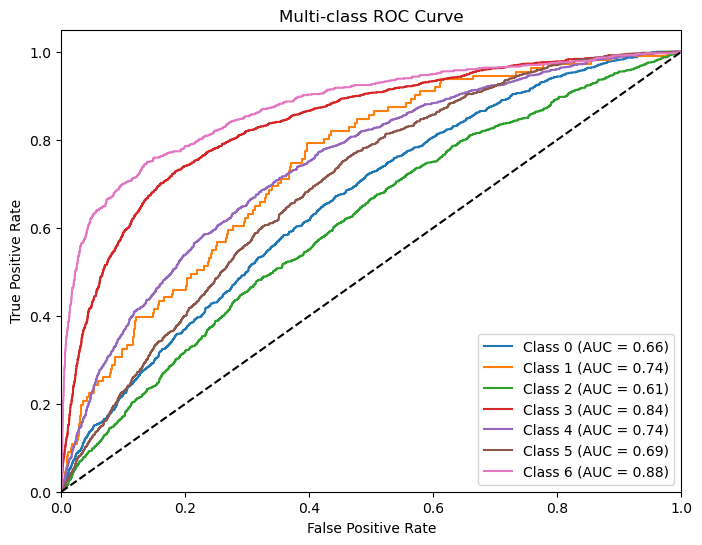

RMSE: 2.1335
R2 Score: -0.4098


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_curve, auc, mean_squared_error, r2_score)
from sklearn.preprocessing import label_binarize

# 테스트셋에 대한 예측 수행
all_probs = model.predict(test_generator)
all_preds = np.argmax(all_probs, axis=1)
all_labels = test_generator.classes

# 1. Accuracy, Precision, Recall, F1 Score 계산
accuracy_val = accuracy_score(all_labels, all_preds)
precision_val = precision_score(all_labels, all_preds, average='weighted')
recall_val = recall_score(all_labels, all_preds, average='weighted')
f1_val = f1_score(all_labels, all_preds, average='weighted')
print("Accuracy: {:.4f}".format(accuracy_val))
print("Precision: {:.4f}".format(precision_val))
print("Recall: {:.4f}".format(recall_val))
print("F1 Score: {:.4f}".format(f1_val))

# 2. 다중 클래스 ROC Curve (one-vs-rest 방식)
n_classes = num_classes  # 혹은 len(test_generator.class_indices)
all_labels_bin = label_binarize(all_labels, classes=range(n_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 3. RMSE와 R2 Score 계산 (클래스 레이블에 대해)
rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
r2 = r2_score(all_labels, all_preds)
print("RMSE: {:.4f}".format(rmse))
print("R2 Score: {:.4f}".format(r2))